## Load Data

In [86]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
import seaborn as sns

In [87]:
df = pd.read_csv("data/bbc.csv")
print(df.head())

   Unnamed: 0                                               news      type
0           0  UK economy facing 'major risks'\n \n The UK ma...  business
1           1  Aids and climate top Davos agenda\n \n Climate...  business
2           2  Asian quake hits European shares\n \n Shares i...  business
3           3  India power shares jump on debut\n \n Shares i...  business
4           4  Lacroix label bought by US firm\n \n Luxury go...  business


In [88]:
df['category_id'] = df['type'].factorize()[0]

In [90]:
colslist = ['index', 'news', 'type', 'category_id']
df.columns = colslist

print(df.head())


   index                                               news      type  \
0      0  UK economy facing 'major risks'\n \n The UK ma...  business   
1      1  Aids and climate top Davos agenda\n \n Climate...  business   
2      2  Asian quake hits European shares\n \n Shares i...  business   
3      3  India power shares jump on debut\n \n Shares i...  business   
4      4  Lacroix label bought by US firm\n \n Luxury go...  business   

   category_id  
0            0  
1            0  
2            0  
3            0  
4            0  


<AxesSubplot: xlabel='type'>

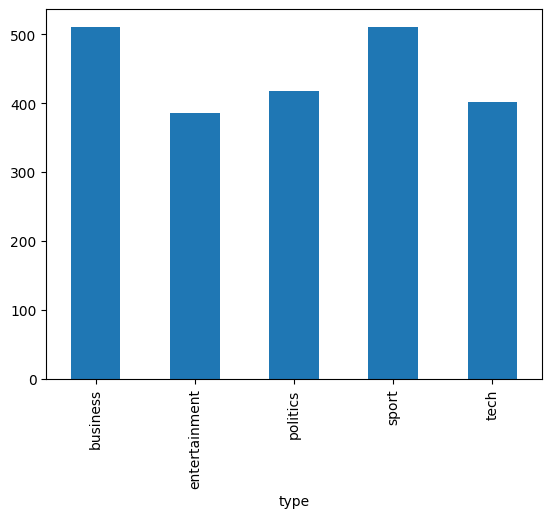

In [92]:
df.groupby('type').index.count().plot.bar(ylim=0)

## Prepare the Data

In [113]:
from nltk.stem import WordNetLemmatizer
import string

stop_words = nltk.corpus.stopwords.words('english')
porter = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [94]:
def lemmatize_words(words):
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word)
        lemmas.append(lemma)
    return lemmas


def preprocess(text):
    lemmas = []
    text = text.lower()
    text_punct = "".join([char for char in text if char not in string.punctuation])
    
    words = word_tokenize(text_punct)
    
    filtered_words = [word for word in words if word not in stop_words]
    
    stemmed = [porter.stem(word) for word in filtered_words]
    stemmed = ' '.join(stemmed)
    #lemmas = lemmatize_words(filtered_words)
    
    return stemmed

In [95]:
df['clean_text'] = df['news'].apply(preprocess)
print(df.shape)

(2225, 5)


## TF-IDF Vectorization

In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [97]:
# sublinear_tf scaling is applied to reduce the effect of very frequent terms in the document
# norm l2: sum of the squares of the vector elements is 1
# Normalization can also help to reduce the impact of very long documents, which may have a higher term frequency than shorter documents. 
# By applying normalization, the importance of each term in the document can be more accurately represented by the tf-idf weighting.
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2))

In [98]:
# Create features and labels
X = tfidf.fit_transform(df.clean_text).toarray()
y = df.category_id
X.shape

(2225, 14722)

In [99]:
freq = pd.Series(' '.join(df['clean_text']).split()).value_counts()
freq2 = freq[freq <= 3]
print(freq2.head())

dust           3
33yearold      3
wagon          3
jeanfrancoi    3
196            3
dtype: int64


In [101]:
# create a lisf of unfrequent words
list_word_freq_3 = list(freq2.index.values)

In [104]:
# create dict with id and category
category_id_df = df[['type', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'type']].values)

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}


In [106]:
from sklearn.feature_selection import chi2

N = 3
for newstype, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(X, y == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(newstype))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))


# 'business':
  . Most correlated unigrams:
       . oil
       . growth
       . bank
  . Most correlated bigrams:
       . analyst said
       . interest rate
       . stock market
# 'entertainment':
  . Most correlated unigrams:
       . star
       . award
       . film
  . Most correlated bigrams:
       . lo angel
       . film festiv
       . box offic
# 'politics':
  . Most correlated unigrams:
       . elect
       . tori
       . labour
  . Most correlated bigrams:
       . prime minist
       . toni blair
       . mr blair
# 'sport':
  . Most correlated unigrams:
       . champion
       . coach
       . cup
  . Most correlated bigrams:
       . australian open
       . grand slam
       . six nation
# 'tech':
  . Most correlated unigrams:
       . technolog
       . comput
       . user
  . Most correlated bigrams:
       . news websit
       . let peopl
       . mobil phone


In [110]:
from sklearn.manifold import TSNE

# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(X) * 0.3)
np.random.seed(0)
indices = np.random.choice(range(len(X)), size=SAMPLE_SIZE, replace=False)
projected_features = TSNE(n_components=2, random_state=0, init='random', learning_rate=200).fit_transform(X[indices])
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']

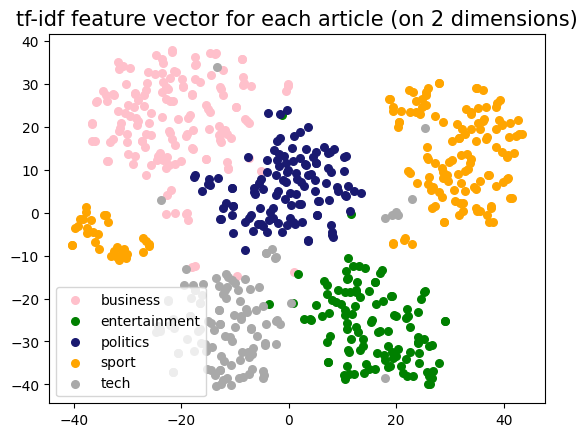

In [112]:
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(y[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)
    
plt.title("tf-idf feature vector for each article (on 2 dimensions)",
          fontdict=dict(fontsize=15))
plt.legend()

## Train Models

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

In [126]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    #SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
]

In [127]:
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

In [128]:
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X, y, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [129]:
print(cv_df)

                model_name  fold_idx  accuracy
0   RandomForestClassifier         0  0.856180
1   RandomForestClassifier         1  0.817978
2   RandomForestClassifier         2  0.838202
3   RandomForestClassifier         3  0.833708
4   RandomForestClassifier         4  0.840449
5            MultinomialNB         0  0.979775
6            MultinomialNB         1  0.970787
7            MultinomialNB         2  0.964045
8            MultinomialNB         3  0.970787
9            MultinomialNB         4  0.970787
10      LogisticRegression         0  0.982022
11      LogisticRegression         1  0.984270
12      LogisticRegression         2  0.982022
13      LogisticRegression         3  0.968539
14      LogisticRegression         4  0.977528


<AxesSubplot: xlabel='model_name', ylabel='accuracy'>

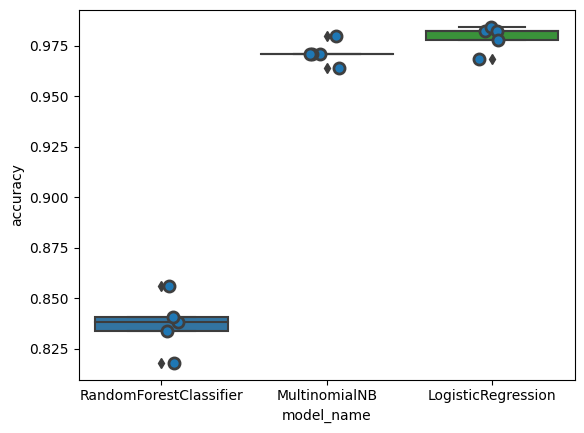

In [130]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,size=8, jitter=True, edgecolor="gray", linewidth=2)

In [132]:
from sklearn.model_selection import train_test_split

model = LogisticRegression(random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

[[169   0   4   0   0]
 [  0 121   1   0   1]
 [  3   1 136   0   0]
 [  0   0   1 172   0]
 [  1   1   0   2 122]]


Text(0.5, 23.52222222222222, 'Predicted')

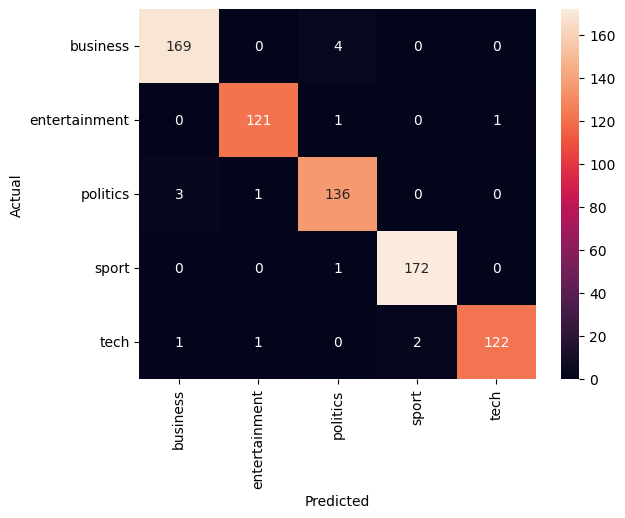

In [140]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
#print(conf_mat)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.type.values, yticklabels=category_id_df.type.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [141]:
texts = ["Hooli stock price soared after a dip in PiedPiper revenue growth.",
         "Captain Tsubasa scores a magnificent goal for the Japanese team.",
         "Merryweather mercenaries are sent on another mission, as government oversight groups call for new sanctions.",
         "Beyoncé releases a new album, tops the charts in all of south-east Asia!",
         "You won't guess what the latest trend in data analysis is!"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
    print('"{}"'.format(text))
    print("  - Predicted as: '{}'".format(id_to_category[predicted]))
    print("")

"Hooli stock price soared after a dip in PiedPiper revenue growth."
  - Predicted as: 'business'

"Captain Tsubasa scores a magnificent goal for the Japanese team."
  - Predicted as: 'sport'

"Merryweather mercenaries are sent on another mission, as government oversight groups call for new sanctions."
  - Predicted as: 'business'

"Beyoncé releases a new album, tops the charts in all of south-east Asia!"
  - Predicted as: 'entertainment'

"You won't guess what the latest trend in data analysis is!"
  - Predicted as: 'business'

